## Mod 5 Project
#### Machine Learning Classification
This project is an analysis of a number of Starcraft 2 players. The goal of the project is to classify players into an appropriate league based on their playing statistics and habits.

Database Source: https://www.kaggle.com/danofer/skillcraft/data#SkillCraft.csv

### Imports & Data Inspection/Cleaning

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

from sklearn import svm, tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('ggplot')

Using TensorFlow backend.


In [226]:
data = pd.read_csv("SkillCraft.csv")
data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [3]:
data.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [4]:
data['GameID'].value_counts()

4094    1
513     1
685     1
4779    1
6826    1
       ..
5300    1
5296    1
7341    1
3243    1
4098    1
Name: GameID, Length: 3338, dtype: int64

In [5]:
#Dropping GameID column as it is just a unique identifier.
data.drop(columns = 'GameID', inplace = True)

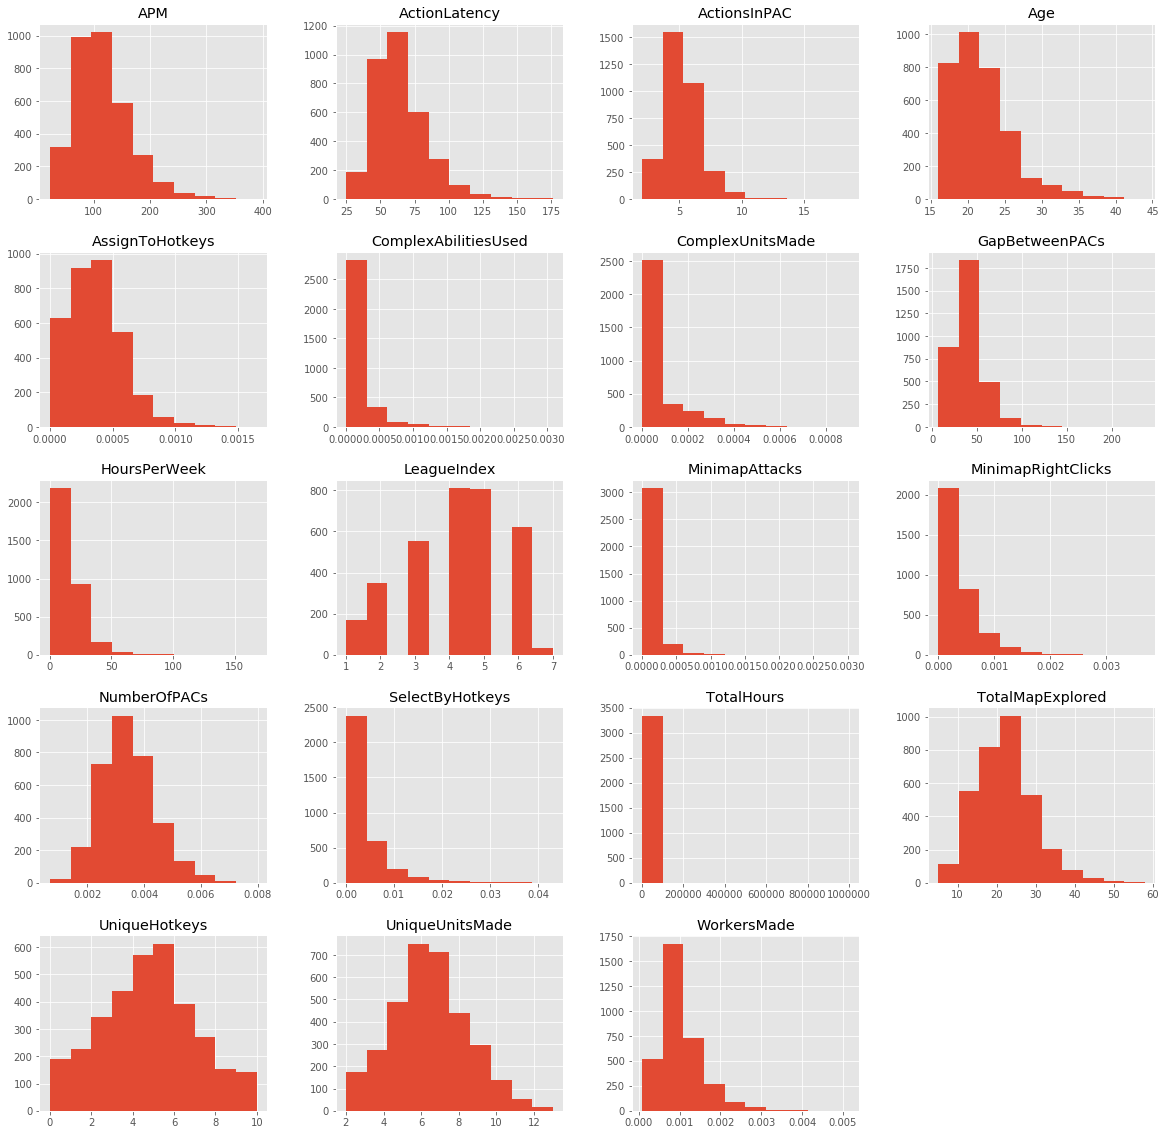

In [89]:
data.hist(figsize = (20, 20))
plt.show()

### Train/Test Split & Normalization

In [227]:
y = data['LeagueIndex']
X = data.drop(columns = 'LeagueIndex')

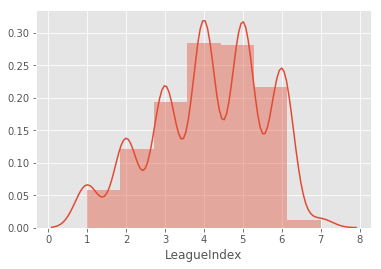

In [194]:
sns.distplot(y, bins = 7)

In [274]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42)

In [275]:
sm = SMOTE()
X_train_sample, y_train_sample = sm.fit_resample(X_train, y_train)
X_train_sample = pd.DataFrame(X_train_sample, 
                              columns = X.columns)

In [276]:
scaler = StandardScaler()
X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

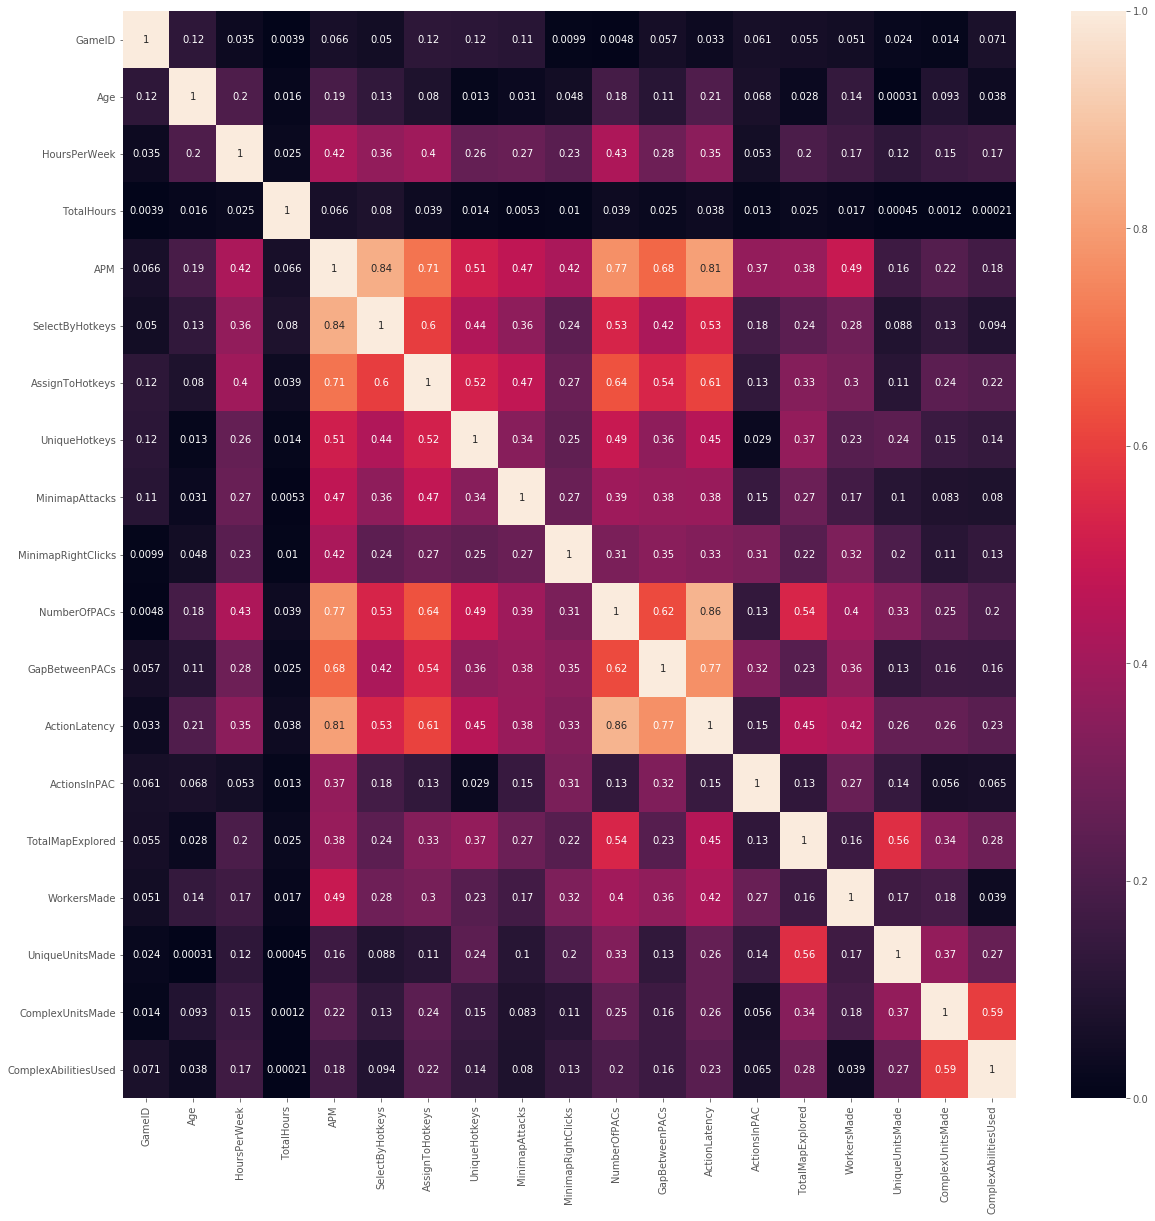

In [277]:
plt.figure(figsize = [20, 20])
sns.heatmap(X_train_scaled_sample.corr().abs(), annot = True)

# Modeling
### Function Creation

In [12]:
def fit_model(clf, X_train, X_test, y_train, y_test,
              param_grid, scoring = 'accuracy', cv = 3,
              feature_importances = None, title = None):
    """
    This function will fit a model using the provided classifier, dataset, 
    and parameter grid. It uses GridSearchCV to determine the best model.
    
    INPUTS:
    clf                 = Classifier to be fit
    X_train,X_test,y_train,y_test = train/test data to be used 
    param_grid          = Parameter grid to be used for the gridsearch
    scoring             = Scoring method to be used for the gridsearch
    cv                  = Number of cross-validations
    feature_importances = Number of top features to print
    title               = Title to print for clarity when reviewing outputs
    
    OUTPUTS:
    Returns the best estimator model from GridSearch. 
    Prints title, score, feature importances to screen.
    """
    grid_clf = GridSearchCV(estimator = clf, param_grid = param_grid, 
                            cv = cv, scoring = scoring)
    grid_clf.fit(X_train, y_train)
    if title:
        print(title)
    print(" BEST PARAMS:")
    print(grid_clf.best_params_)
    print("\nBest", scoring.capitalize() ,"Score:",round(grid_clf.best_score_,4))

    #Get Stats for Train Test Split just to verify that crossvalidation was good.
    print_model_stats(grid_clf, X_train, X_test, y_train, y_test)
    if feature_importances:
        try:
            print("")
            get_feature_importances(grid_clf.best_estimator_, X_train, num_features=feature_importances)
        except:
            pass
    return grid_clf.best_estimator_

In [13]:
def get_feature_importances(estimator, df, num_features=10):
    """
    This function will print the feature importances from the provided model
    and dataframe.
    
    INPUTS:
    estimator    = The model that has been fit.
    df           = The dataframe containing model features.
    num_features = The number of features to print.
    """
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    if len(importances) < num_features:
        num_features = len(importances)
    print("Feature ranking:")
    for idx, f_idx in enumerate(indices[0:num_features]):
        print(f"{idx+1}: Score {round(importances[f_idx],3)}, Feature Name: {df.columns[f_idx]}")
    return

In [14]:
def print_model_stats(estimator, X_train, X_test, y_train, y_test):
    """
    This function prints the accuracy and precision score for the provided
    model using the training and test datasets provided.
    """
    y_pred_train = estimator.predict(X_train)
    y_pred_test  = estimator.predict(X_test)
    print(" TRAINING:  Accuracy:",round(accuracy_score(y_train,y_pred_train),4))
    print(" TEST:      Accuracy:",round(accuracy_score(y_test,y_pred_test),4))   
    return

### Creating Classifiers & Parameter Grids

In [287]:
rf_clf = RandomForestClassifier()
param_grid_rf = [{'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 2, 4, 6, 8, 10],
                  'n_estimators': [50, 100],
                  'max_features': ['auto', 5, 8, 10]}]

In [16]:
xgb_clf = XGBClassifier()
param_grid_xgb = [{'max_depth': [2, 3, 4, 5],
                   'n_estimators': [50, 100],
                   'learning_rate': [0.1, 0.2],
                   'gamma': [0, 1] }]

In [17]:
svc_clf = SVC()
param_grid_svc = [{'C': [1.0],
                   'gamma': ['auto'] }]

In [18]:
ovrx_clf = OneVsRestClassifier(XGBClassifier())
param_grid_ovrx = [{'estimator__max_depth': [2, 3, 4, 5],
                   'estimator__n_estimators': [50, 100],
                   'estimator__learning_rate': [0.1, 0.2],
                   'estimator__gamma': [0, 1] }]

In [19]:
ovrs_clf = OneVsRestClassifier(SVC())
param_grid_ovrs = [{'estimator__C': [1.0],
                   'estimator__gamma': ['auto'] }]

### Testing Models

In [20]:
fit_model(rf_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.6582
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.3523

Feature ranking:
1: Score 0.135, Feature Name: ActionLatency
2: Score 0.106, Feature Name: APM
3: Score 0.079, Feature Name: NumberOfPACs
4: Score 0.073, Feature Name: SelectByHotkeys
5: Score 0.072, Feature Name: TotalHours
6: Score 0.068, Feature Name: MinimapAttacks
7: Score 0.066, Feature Name: AssignToHotkeys
8: Score 0.064, Feature Name: GapBetweenPACs


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
fit_model(xgb_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6195
 TRAINING:  Accuracy: 0.996
 TEST:      Accuracy: 0.3004


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
fit_model(svc_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.5317
 TRAINING:  Accuracy: 0.6357
 TEST:      Accuracy: 0.3343


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
fit_model(ovrx_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6225
 TRAINING:  Accuracy: 0.9983
 TEST:      Accuracy: 0.2934


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [24]:
fit_model(ovrs_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5308
 TRAINING:  Accuracy: 0.7197
 TEST:      Accuracy: 0.2854


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### Removing Multi-Colinearity

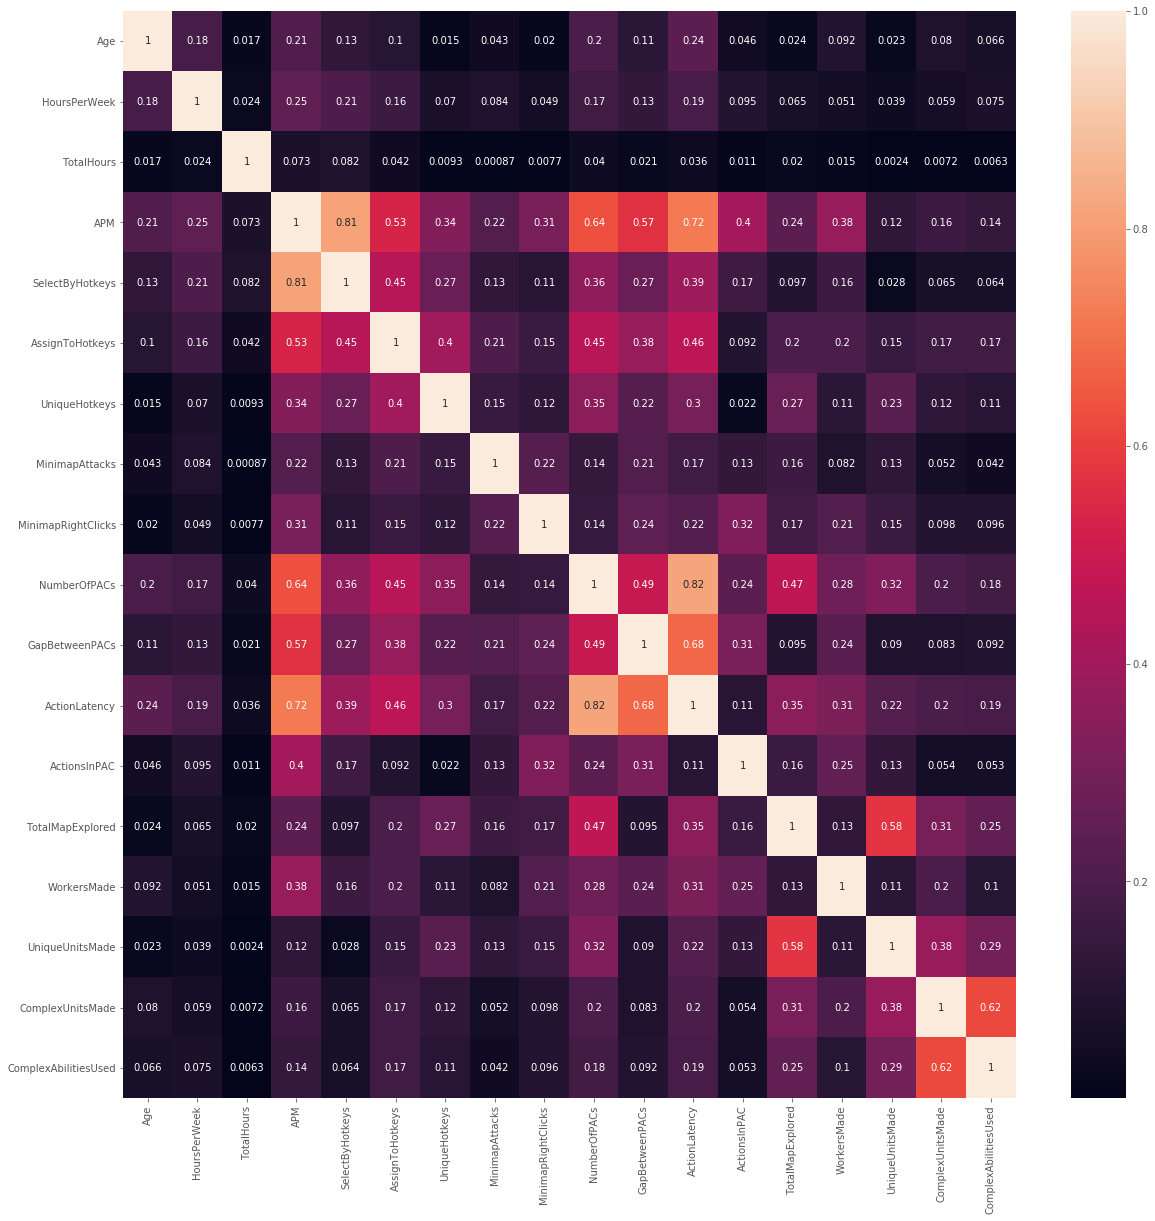

In [25]:
plt.figure(figsize = [20, 20])
sns.heatmap(X.corr().abs(), annot = True)

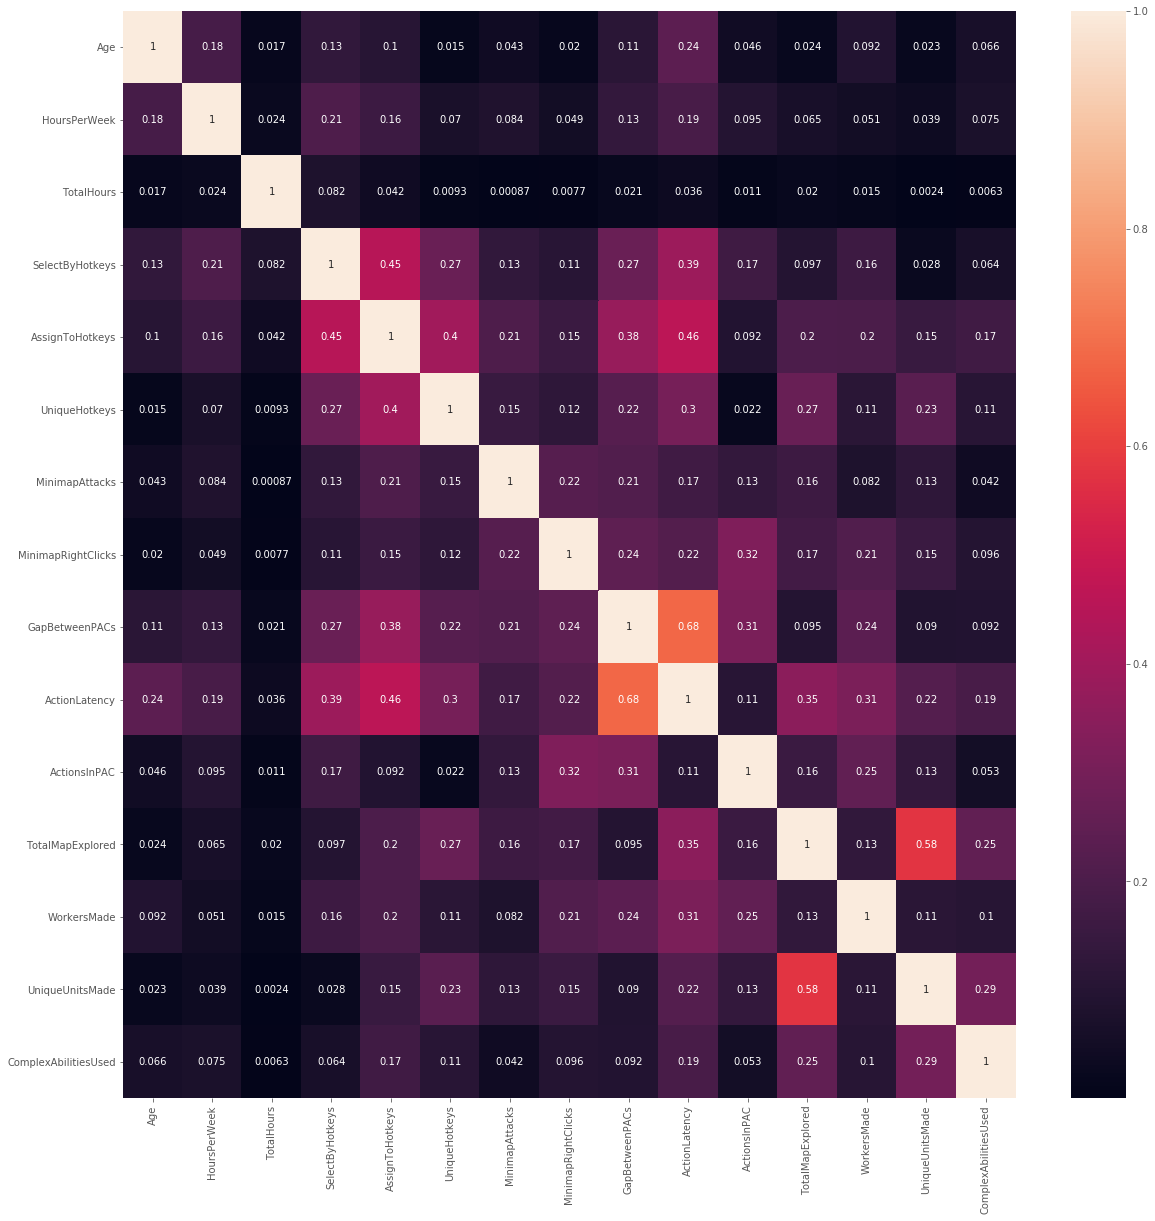

In [32]:
columns_to_remove = ['APM', 'NumberOfPACs', 'ComplexUnitsMade']
X_filtered = X.drop(columns = columns_to_remove)
plt.figure(figsize = [20, 20])
sns.heatmap(X_filtered.corr().abs(), annot = True)

In [37]:
X_filt_train, X_filt_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size = 0.30, random_state = 42)

In [38]:
sm = SMOTE()
X_filt_train_sample, y_train_sample = sm.fit_resample(X_filt_train, y_train)
X_filt_train_sample = pd.DataFrame(X_filt_train_sample, 
                              columns = X_filtered.columns)

In [39]:
scaler = StandardScaler()
X_filt_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_filt_train_sample), 
                              columns = X_filtered.columns, index = X_filt_train_sample.index)
X_filt_test_scaled = pd.DataFrame(scaler.fit_transform(X_filt_test), 
                              columns = X_filtered.columns, index = X_filt_test.index)

In [40]:
fit_model(rf_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.6714
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.3663

Feature ranking:
1: Score 0.127, Feature Name: ActionLatency
2: Score 0.1, Feature Name: SelectByHotkeys
3: Score 0.09, Feature Name: GapBetweenPACs
4: Score 0.081, Feature Name: TotalHours
5: Score 0.08, Feature Name: MinimapAttacks
6: Score 0.079, Feature Name: AssignToHotkeys
7: Score 0.058, Feature Name: UniqueHotkeys
8: Score 0.055, Feature Name: WorkersMade


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
fit_model(xgb_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.62
 TRAINING:  Accuracy: 0.9908
 TEST:      Accuracy: 0.2774


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [42]:
fit_model(svc_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.5265
 TRAINING:  Accuracy: 0.6334
 TEST:      Accuracy: 0.3253


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
fit_model(ovrx_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6248
 TRAINING:  Accuracy: 0.9953
 TEST:      Accuracy: 0.3034


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [44]:
fit_model(ovrs_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.529
 TRAINING:  Accuracy: 0.7163
 TEST:      Accuracy: 0.2974


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### PCA

In [45]:
pca = PCA()
X_train_sample_trans = pd.DataFrame(pca.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_trans = pd.DataFrame(pca.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

In [46]:
fit_model(rf_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.662
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.1876

Feature ranking:
1: Score 0.22, Feature Name: HoursPerWeek
2: Score 0.123, Feature Name: Age
3: Score 0.065, Feature Name: TotalHours
4: Score 0.048, Feature Name: APM
5: Score 0.044, Feature Name: NumberOfPACs
6: Score 0.044, Feature Name: MinimapAttacks
7: Score 0.043, Feature Name: UniqueUnitsMade
8: Score 0.043, Feature Name: GapBetweenPACs


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
fit_model(xgb_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6248
 TRAINING:  Accuracy: 0.9943
 TEST:      Accuracy: 0.1776


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [48]:
fit_model(svc_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.4221
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.2355


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
fit_model(ovrx_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 1, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6238
 TRAINING:  Accuracy: 0.997
 TEST:      Accuracy: 0.1856


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [50]:
fit_model(ovrs_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5126
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.2345


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

# Refinement
As none of our models have had better than about 36% accuracy thus far, the next step will be to try reducing the number of classes down to three (Beginner, Advanced, and Expert). The original classes will be binned as 1-3 (Bronze, Silver, Gold) into Beginner, 4 and 5 (Platinum and Diamond) into Advanced, and 6 and 7 (Master and Grandmaster) into Expert.

In [229]:
y.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64

In [228]:
y_group = y.map(lambda x: 'Beginner' if x in [1, 2, 3] else 
                'Advanced' if x in [4, 5] else 'Expert')
y_group.head()

0    Advanced
1    Advanced
2    Advanced
3    Beginner
4    Beginner
Name: LeagueIndex, dtype: object

In [53]:
y_group.value_counts()

Advanced    1615
Beginner    1067
Expert       656
Name: LeagueIndex, dtype: int64

In [54]:
X_train, X_test, y_group_train, y_group_test = train_test_split(
    X, y_group, test_size = 0.30, random_state = 42)

In [55]:
sm = SMOTE()
X_train_sample, y_group_train_sample = sm.fit_resample(X_train, y_group_train)
X_train_sample = pd.DataFrame(X_train_sample, 
                              columns = X.columns)

In [56]:
scaler = StandardScaler()
X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

### Initial Models

In [57]:
fit_model(rf_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.7607
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6617

Feature ranking:
1: Score 0.147, Feature Name: ActionLatency
2: Score 0.105, Feature Name: APM
3: Score 0.085, Feature Name: NumberOfPACs
4: Score 0.077, Feature Name: TotalHours
5: Score 0.073, Feature Name: SelectByHotkeys
6: Score 0.066, Feature Name: AssignToHotkeys
7: Score 0.063, Feature Name: GapBetweenPACs
8: Score 0.058, Feature Name: MinimapAttacks


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [58]:
fit_model(xgb_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.7265
 TRAINING:  Accuracy: 0.9901
 TEST:      Accuracy: 0.509


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [59]:
fit_model(svc_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.704
 TRAINING:  Accuracy: 0.7688
 TEST:      Accuracy: 0.6327


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
fit_model(ovrx_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.7312
 TRAINING:  Accuracy: 0.944
 TEST:      Accuracy: 0.512


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [61]:
fit_model(ovrs_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.6906
 TRAINING:  Accuracy: 0.7726
 TEST:      Accuracy: 0.5918


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### Removing Multi-Collinearity
Based on the Feature Ranking from our Random Forest, we'll remove the features with the most collinearity and the least effect.

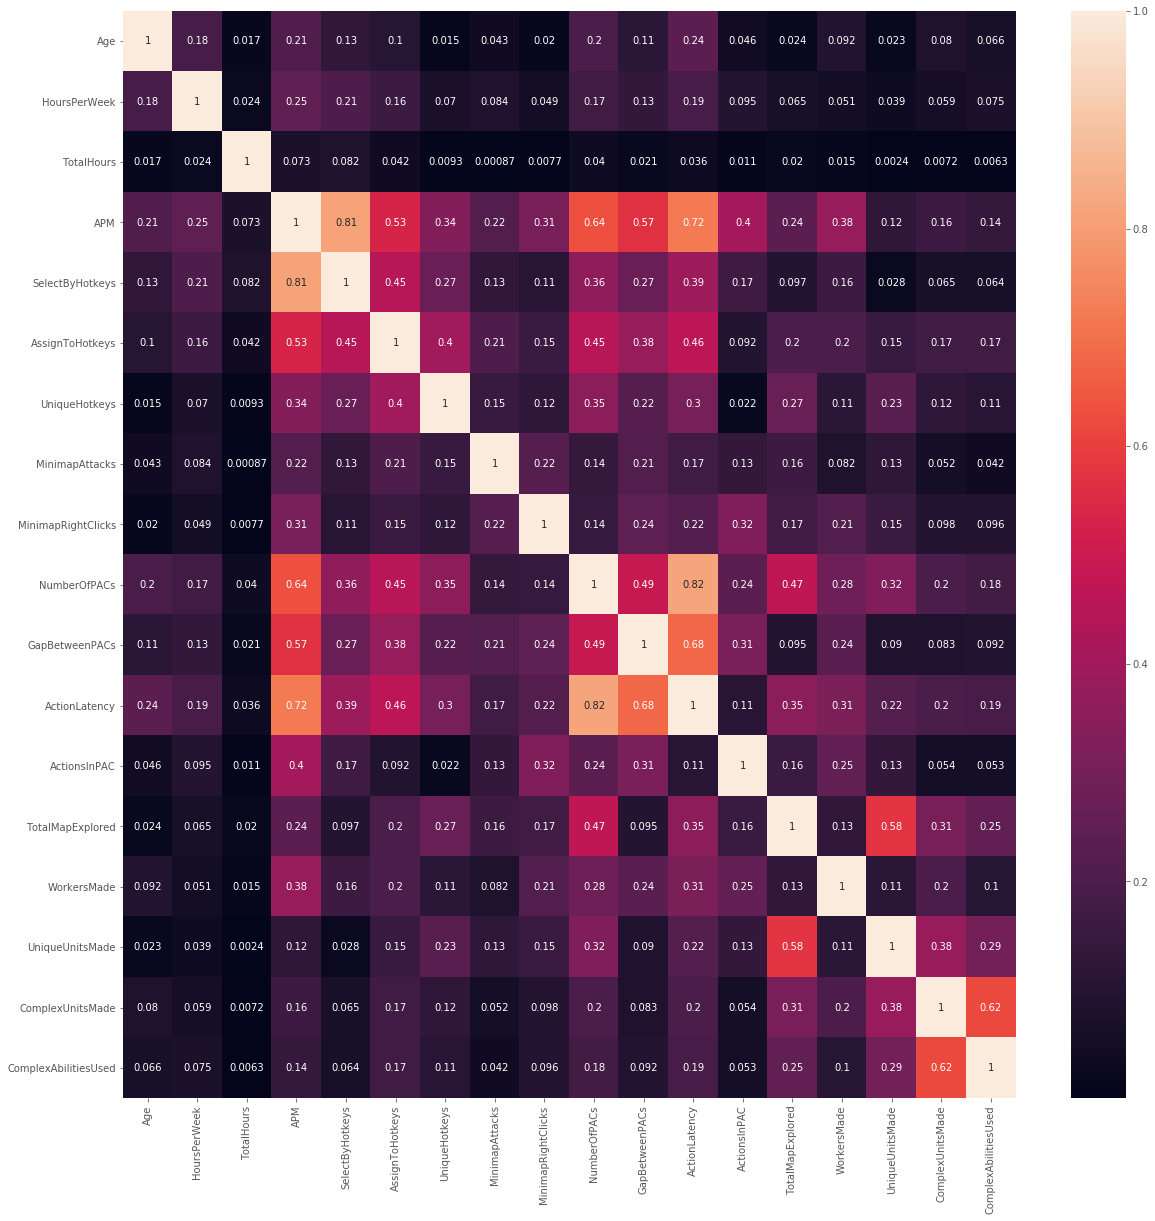

In [62]:
plt.figure(figsize = [20, 20])
sns.heatmap(X.corr().abs(), annot = True)

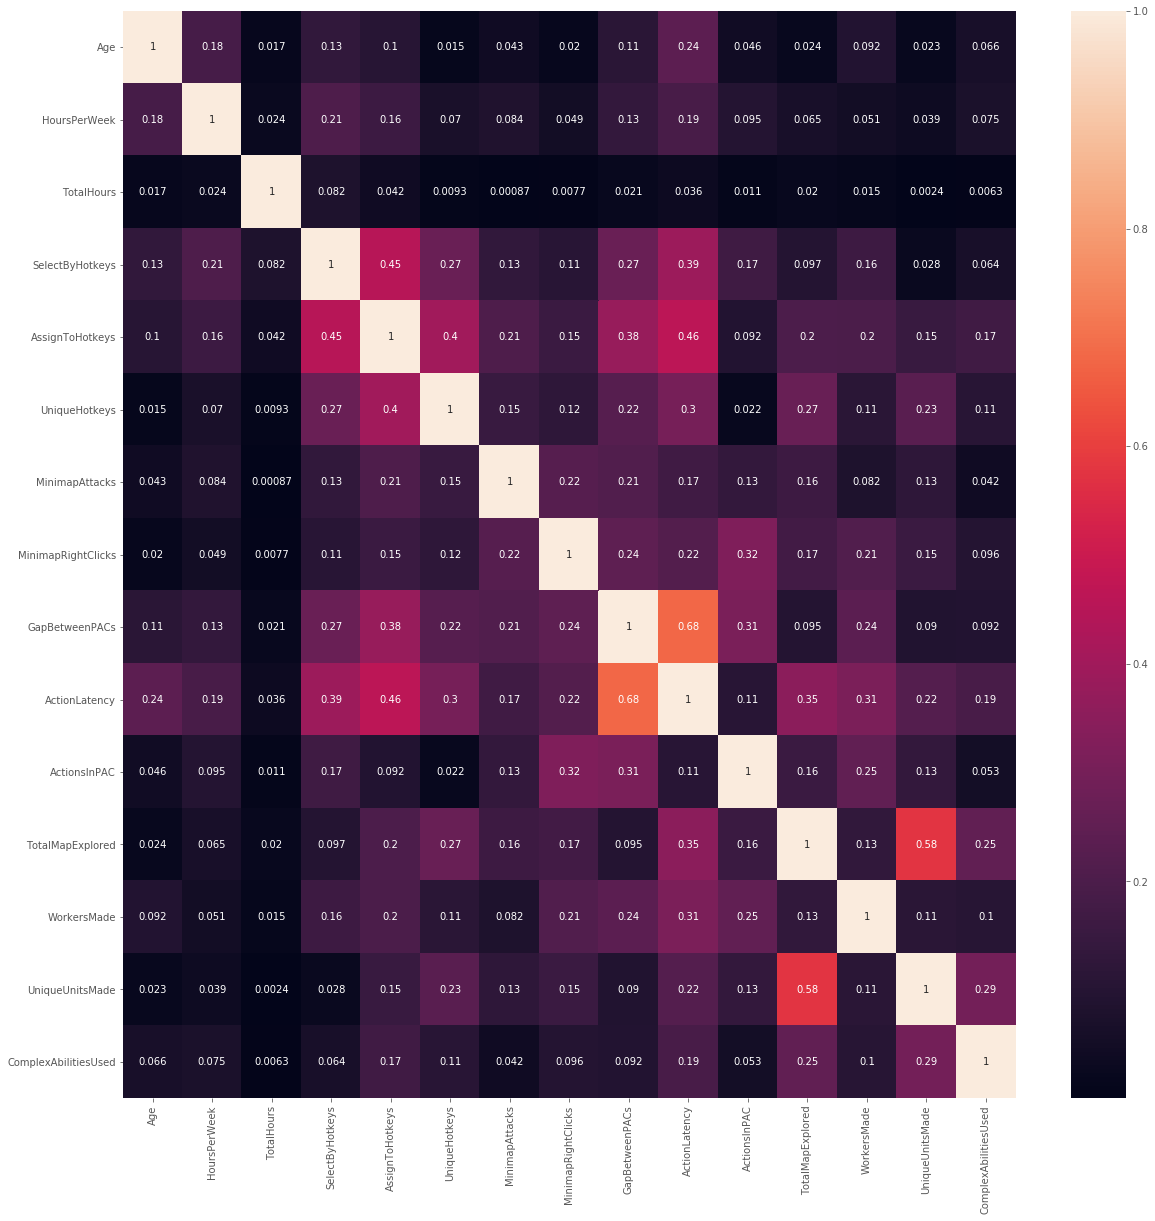

In [63]:
columns_to_remove = ['APM', 'NumberOfPACs', 'ComplexUnitsMade']
X_filtered = X.drop(columns = columns_to_remove)
plt.figure(figsize = [20, 20])
sns.heatmap(X_filtered.corr().abs(), annot = True)

In [64]:
X_filt_train, X_filt_test, y_group_train, y_group_test = train_test_split(
    X_filtered, y_group, test_size = 0.30, random_state = 42)

In [65]:
sm = SMOTE()
X_filt_train_sample, y_group_train_sample = sm.fit_resample(X_filt_train, y_group_train)
X_filt_train_sample = pd.DataFrame(X_filt_train_sample, 
                              columns = X_filtered.columns)

In [66]:
scaler = StandardScaler()
X_filt_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_filt_train_sample), 
                              columns = X_filtered.columns, index = X_filt_train_sample.index)
X_filt_test_scaled = pd.DataFrame(scaler.fit_transform(X_filt_test), 
                              columns = X_filtered.columns, index = X_filt_test.index)

In [67]:
fit_model(rf_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.7665
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6467

Feature ranking:
1: Score 0.185, Feature Name: ActionLatency
2: Score 0.103, Feature Name: SelectByHotkeys
3: Score 0.094, Feature Name: GapBetweenPACs
4: Score 0.093, Feature Name: TotalHours
5: Score 0.08, Feature Name: AssignToHotkeys
6: Score 0.066, Feature Name: MinimapAttacks
7: Score 0.053, Feature Name: WorkersMade
8: Score 0.052, Feature Name: UniqueHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
fit_model(xgb_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}

Best Accuracy Score: 0.7271
 TRAINING:  Accuracy: 0.9305
 TEST:      Accuracy: 0.514


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
fit_model(svc_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.7029
 TRAINING:  Accuracy: 0.7709
 TEST:      Accuracy: 0.6218


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
fit_model(ovrx_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.7285
 TRAINING:  Accuracy: 0.9372
 TEST:      Accuracy: 0.519


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [71]:
fit_model(ovrs_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.6938
 TRAINING:  Accuracy: 0.7729
 TEST:      Accuracy: 0.5968


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

# Results & Conclusion

Thus far, our best model was the Random Forest after reducing our number of classes down to three and removing a number of multi-collinear features.

In [78]:
best_estimator = GridSearchCV(rf_clf, param_grid_rf, cv = 3, scoring = 'accuracy')
best_estimator.fit(X_filt_train_scaled_sample, y_group_train_sample)
y_pred = best_estimator.best_estimator_.predict(X_filt_test_scaled)

Text(0.5, 1.0, 'Random Forest Best Estimator Actual vs Predicted Values')

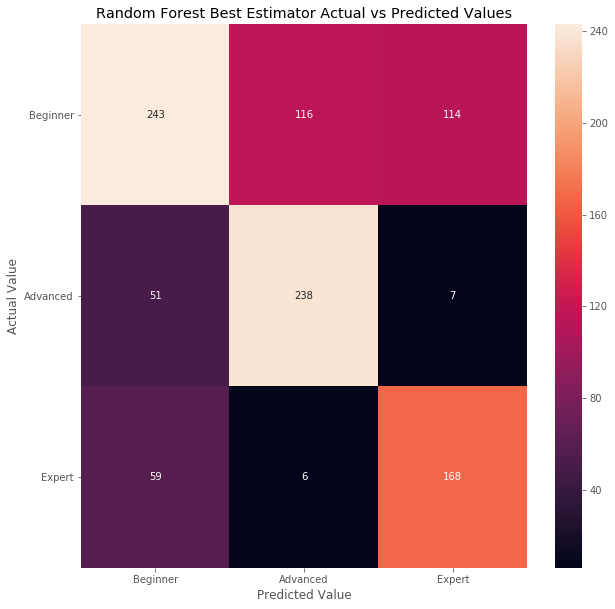

In [79]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(y_group_test, y_pred), annot = True, fmt = 'g', 
            xticklabels = ['Beginner', 'Advanced', 'Expert'], 
            yticklabels = ['Beginner', 'Advanced', 'Expert'])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.yticks(rotation = 0)
plt.title("Random Forest Best Estimator Actual vs Predicted Values")

As you can see from the Confusion Matrix, we're still only about 66% accurate, and tend to miss the Beginner rank the most. This is most likely due to the fact that most players are able to play at a higher tier but aren't able to devote the time to get through the lower ranks of Bronze, Silver, and Gold. 

# Future Work
I would like to continue pushing on this, and figure out a way to adjust for those Beginner tier misclassifications, however I feel like the best way to go about that would be to more heavily weight the TotalHours feature, assuming that it is indeed the reason for those misses. If it's not, I have no idea where to go from there.

I would also like to eventually take each tier and create a model to further classify them back down into each league, if possible. The hardest tier to do would likely be Expert as the Grandmaster tier is very small by comparison.

# Additional EDA and Feature Engineering
To start off this section, I'll be creating Box Plots for each feature, comparing each group, and removing a handful of ridiculous outliers without losing too much data.

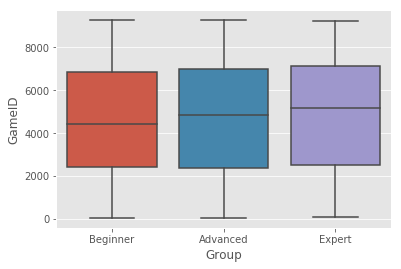

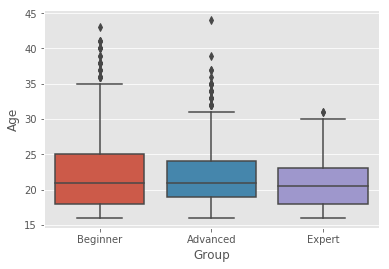

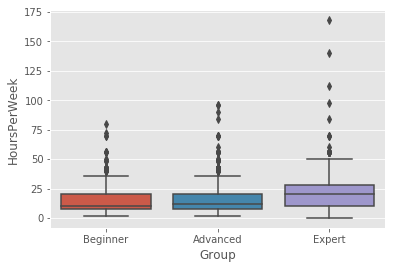

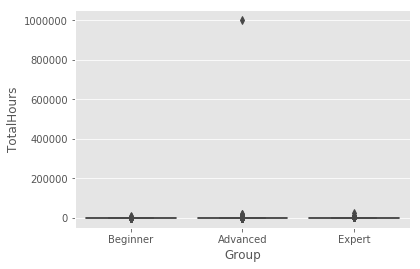

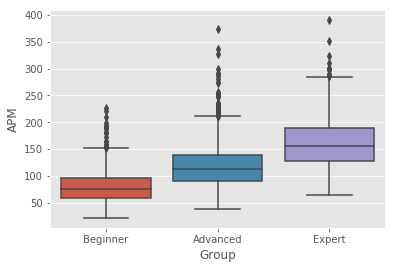

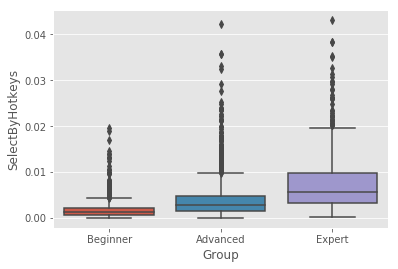

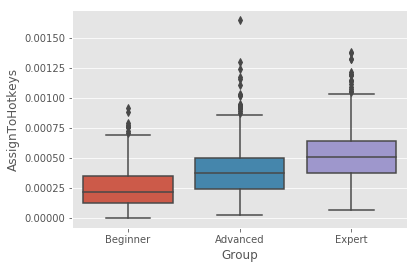

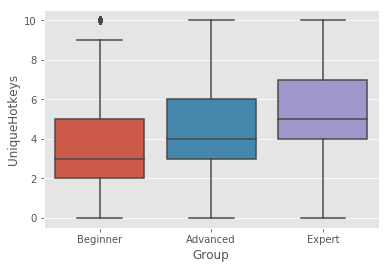

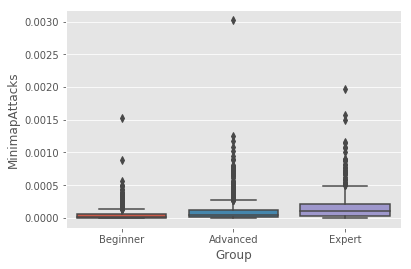

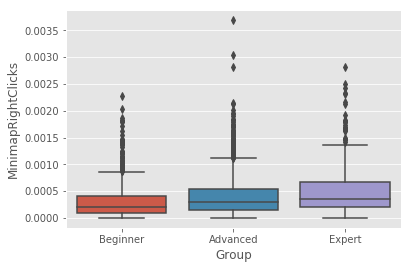

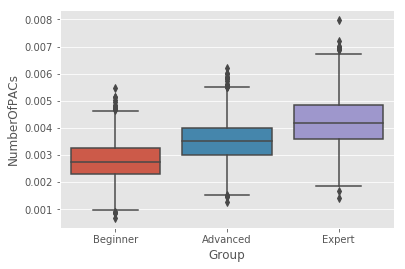

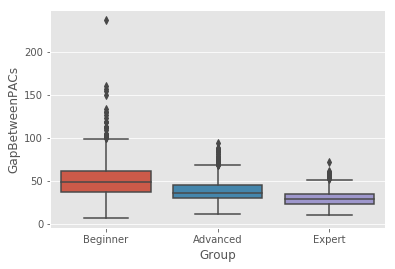

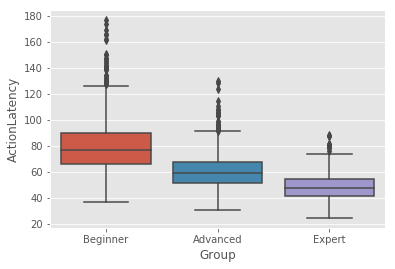

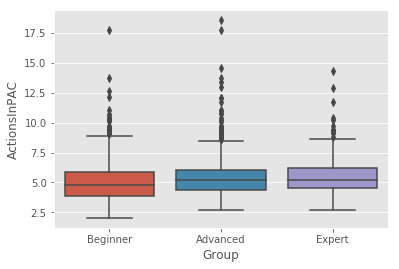

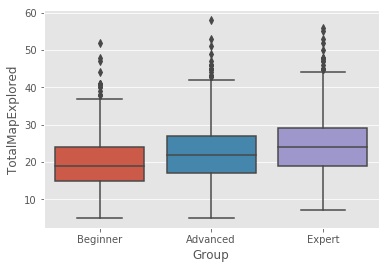

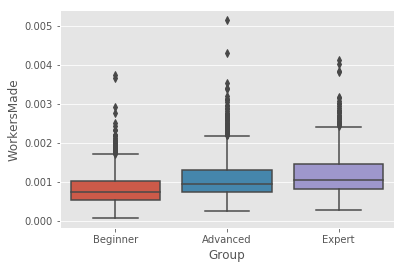

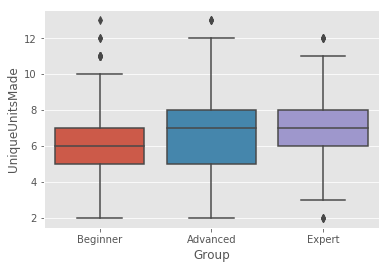

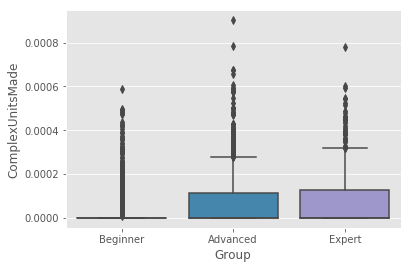

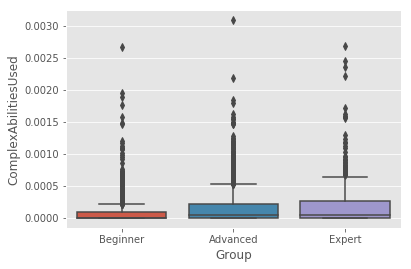

In [230]:
new_data = X.copy()
new_data['Group'] = y_group.values
new_data.head()
for col in X.columns:
    sns.boxplot(y = new_data[col], x = new_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [252]:
todrop = data[(data['HoursPerWeek'] > 100) | 
              (data['TotalHours'] > 3000) | 
              (data['MinimapAttacks'] > 0.00150)].index
new_data = data.drop(todrop)
new_data.drop('GameID', axis = 1, inplace = True)

In [253]:
new_y = new_data['LeagueIndex']
new_X = new_data.drop(columns = 'LeagueIndex')

In [254]:
new_y_group = new_y.map(lambda x: 'Beginner' if x in [1, 2, 3] else 
                'Advanced' if x in [4, 5] else 'Expert')
new_y_group.head()

0    Advanced
2    Advanced
3    Beginner
4    Beginner
5    Beginner
Name: LeagueIndex, dtype: object

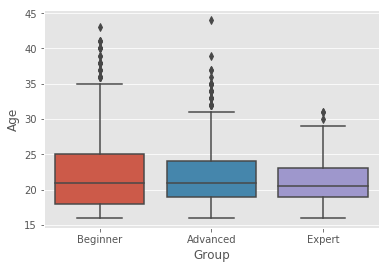

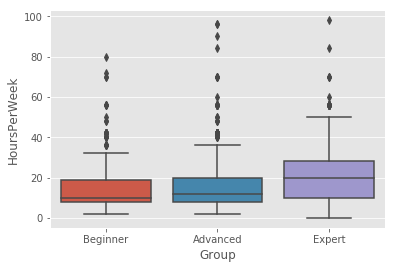

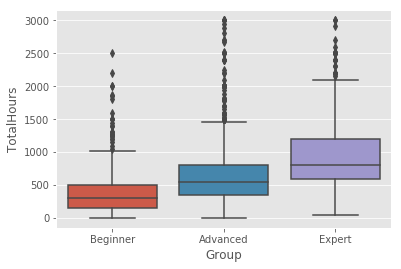

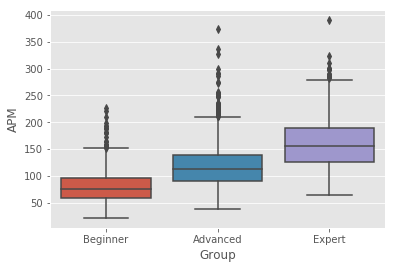

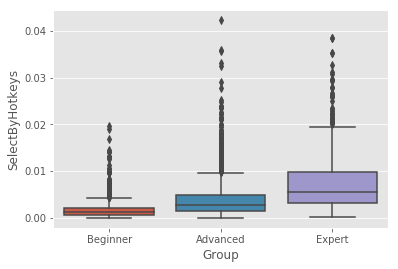

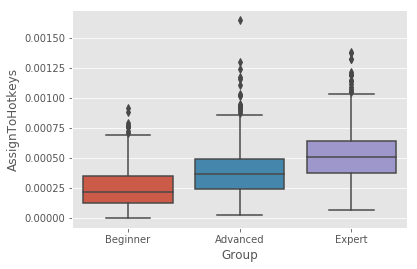

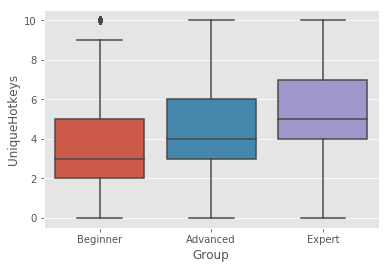

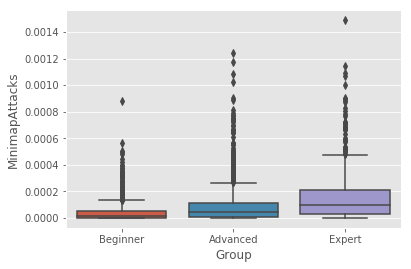

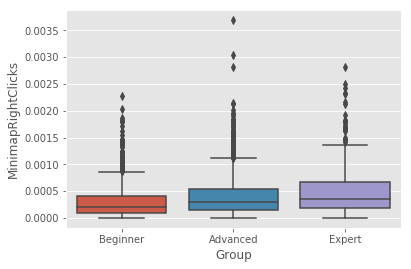

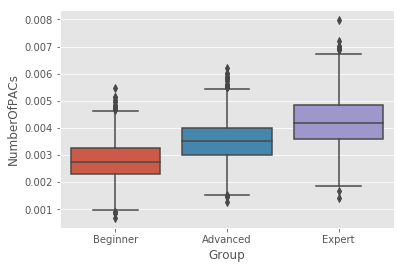

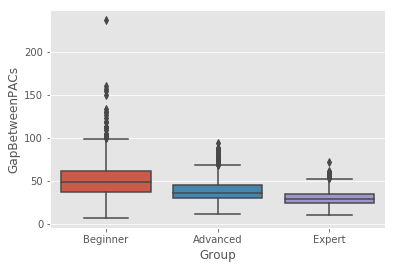

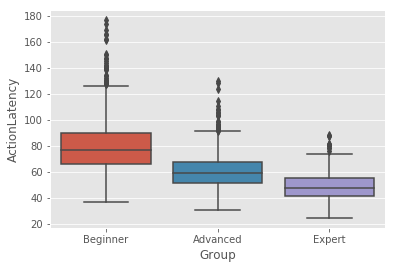

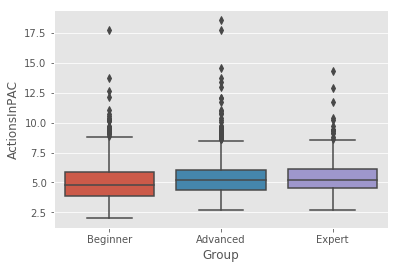

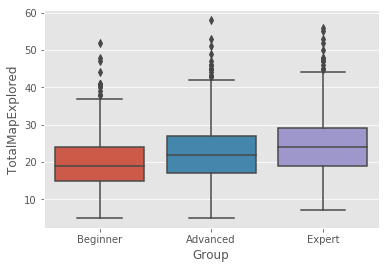

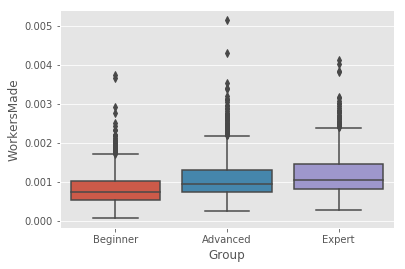

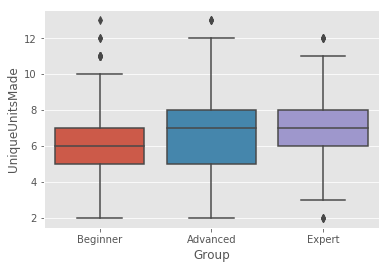

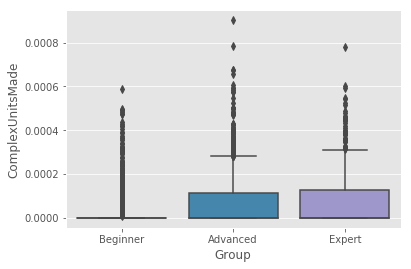

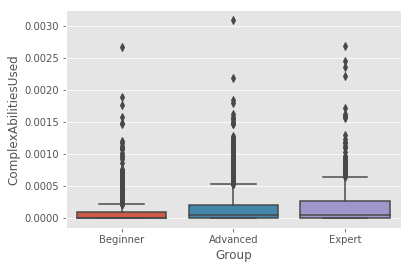

In [262]:
new_new_data = new_X.copy()
new_new_data['Group'] = new_y_group.values
for col in new_X.columns:
    sns.boxplot(y = new_new_data[col], x = new_new_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [263]:
new_new_data['ApproxYrsPlayed'] = (new_new_data['TotalHours'] / new_new_data['HoursPerWeek']) / 52

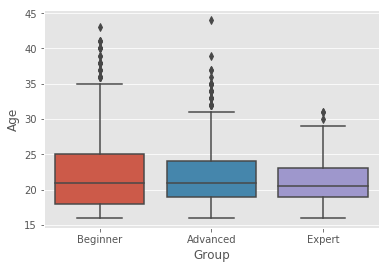

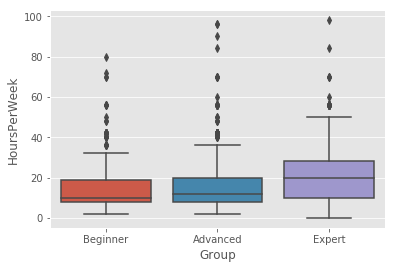

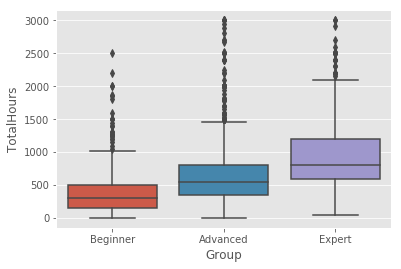

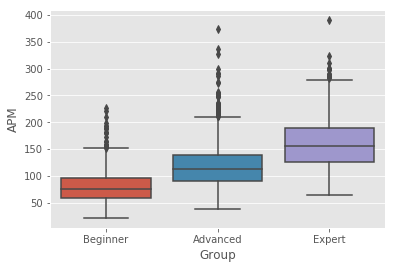

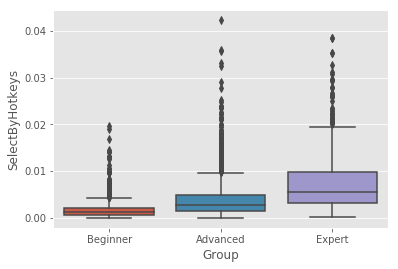

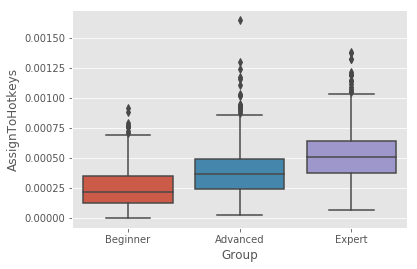

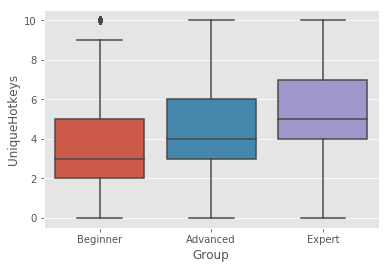

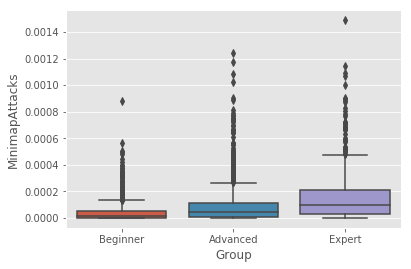

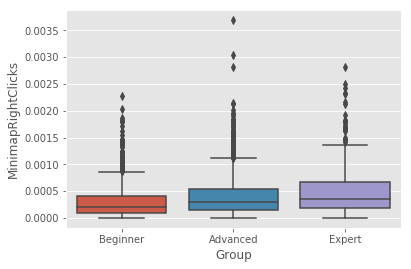

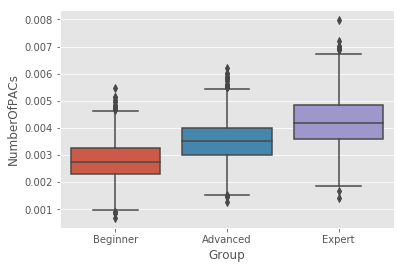

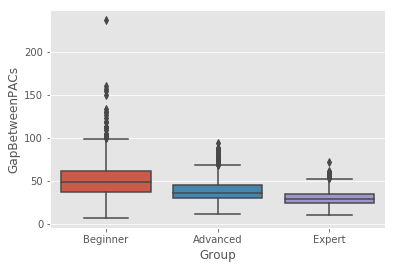

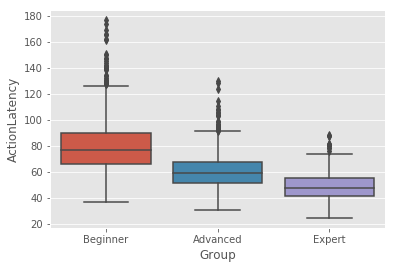

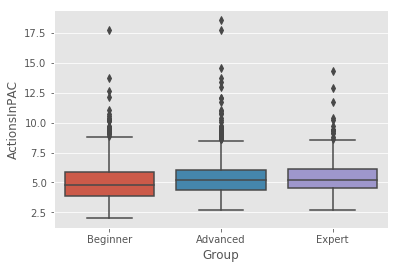

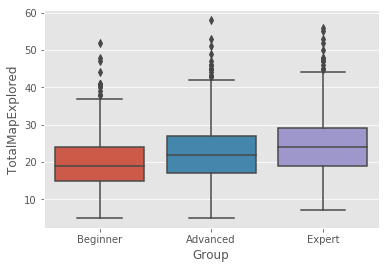

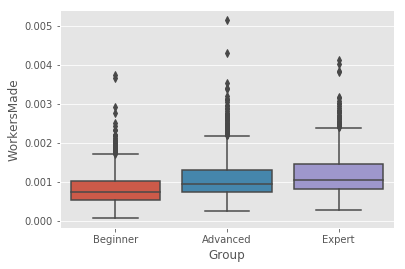

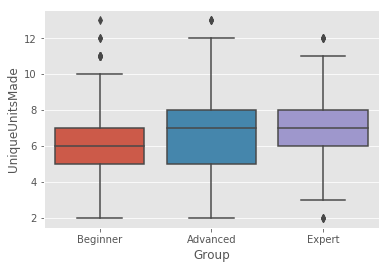

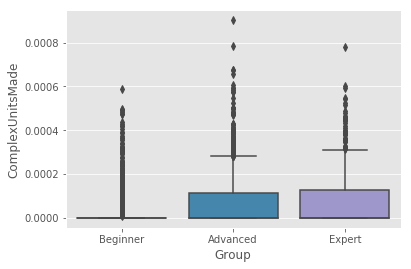

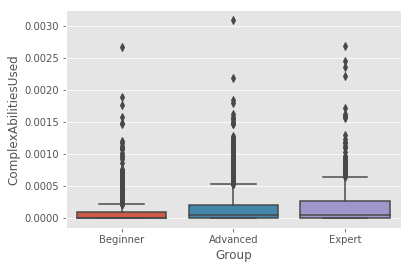

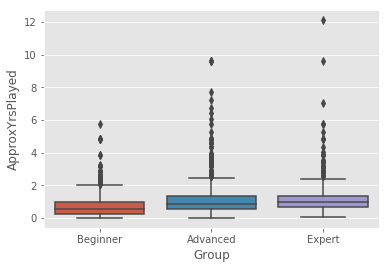

In [264]:
for col in new_new_data.drop('Group', axis = 1).columns:
    sns.boxplot(y = new_new_data[col], x = new_new_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [266]:
todrop = new_new_data[new_new_data['ApproxYrsPlayed'] > 6].index
fixed_data = new_new_data.drop(todrop)

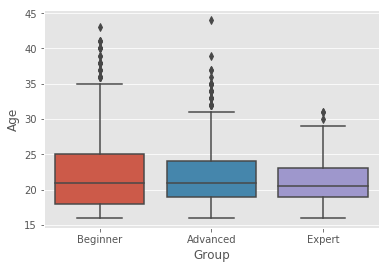

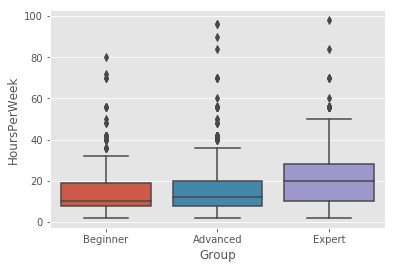

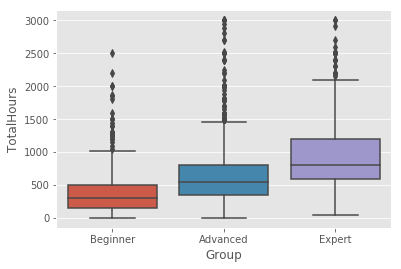

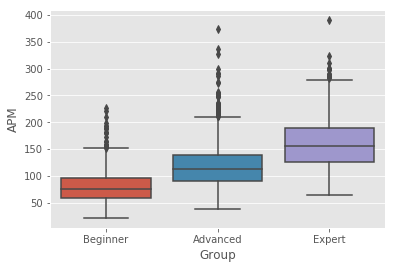

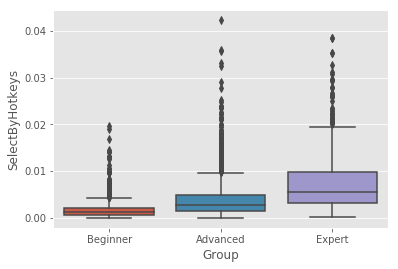

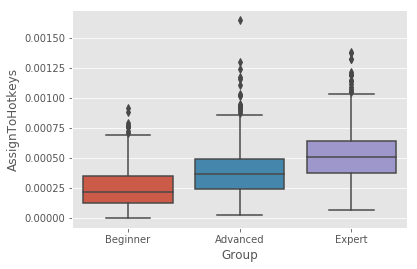

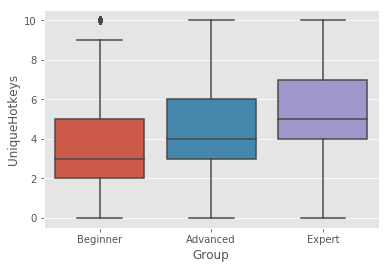

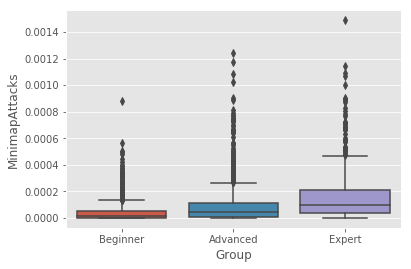

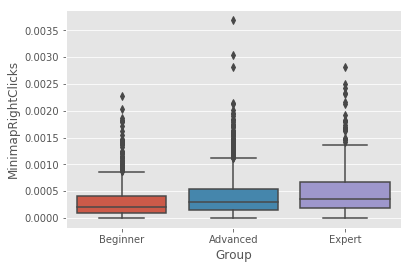

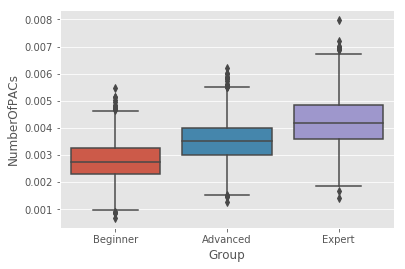

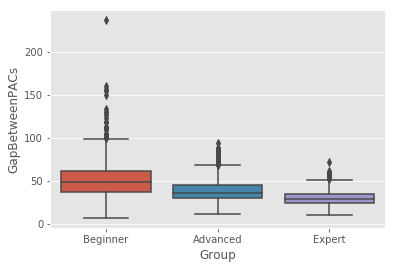

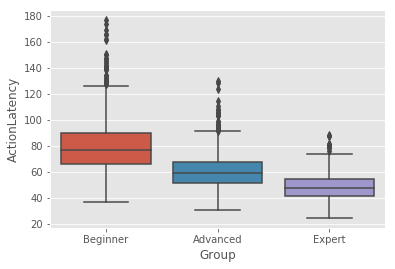

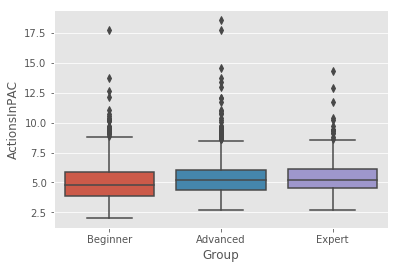

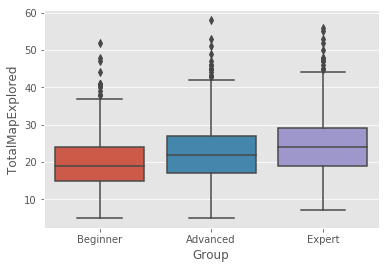

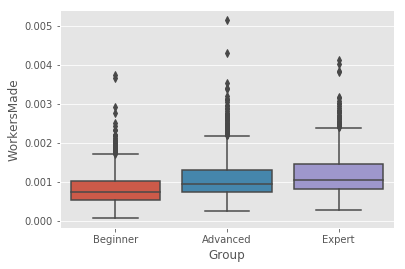

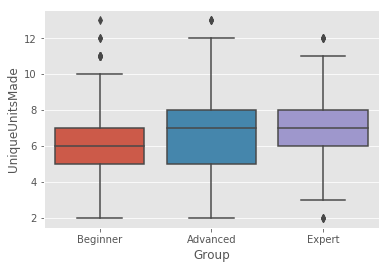

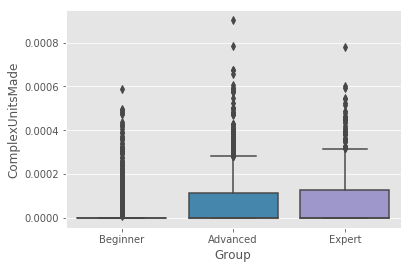

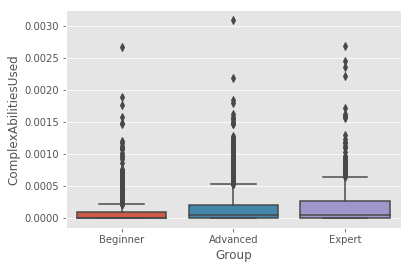

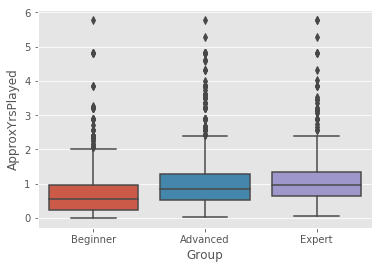

In [267]:
for col in fixed_data.drop('Group', axis = 1).columns:
    sns.boxplot(y = fixed_data[col], x = fixed_data['Group'], order = ['Beginner', 'Advanced', 'Expert'])
    plt.show()

In [269]:
fixed_y = fixed_data['Group']
fixed_X = fixed_data.drop('Group', axis = 1)

In [271]:
fixed_X_train, fixed_X_test, fixed_y_train, fixed_y_test = train_test_split(
    fixed_X, fixed_y, test_size = 0.30, random_state = 42)

In [278]:
sm = SMOTE()
fixed_X_train_sample, fixed_y_train_sample = sm.fit_resample(fixed_X_train, fixed_y_train)
fixed_X_train_sample = pd.DataFrame(fixed_X_train_sample, 
                              columns = fixed_X.columns)

In [279]:
scaler = StandardScaler()
fixed_X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(fixed_X_train_sample), 
                              columns = fixed_X.columns)
fixed_X_test_scaled = pd.DataFrame(scaler.fit_transform(fixed_X_test), 
                              columns = fixed_X.columns, index = fixed_X_test.index)

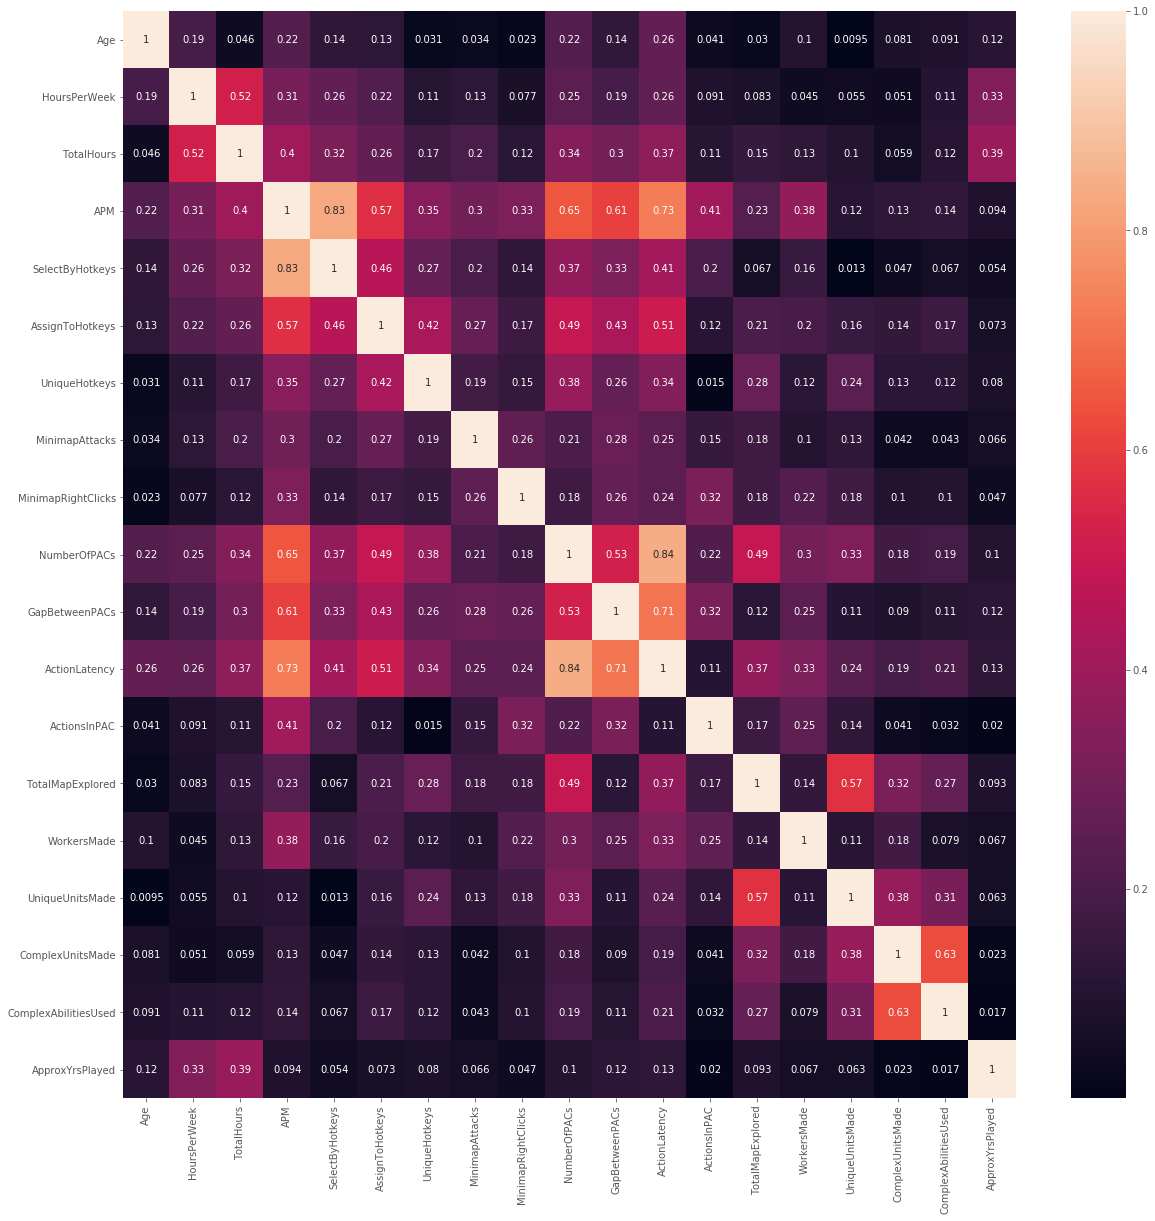

In [280]:
plt.figure(figsize = [20, 20])
sns.heatmap(fixed_X_train_scaled_sample.corr().abs(), annot = True)

In [289]:
fit_model(rf_clf, fixed_X_train_scaled_sample, fixed_X_test_scaled, fixed_y_train_sample, fixed_y_test, 
          param_grid_rf, feature_importances = 10, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 100}

Best Accuracy Score: 0.7668
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6579

Feature ranking:
1: Score 0.142, Feature Name: ActionLatency
2: Score 0.1, Feature Name: APM
3: Score 0.086, Feature Name: TotalHours
4: Score 0.075, Feature Name: SelectByHotkeys
5: Score 0.065, Feature Name: NumberOfPACs
6: Score 0.064, Feature Name: MinimapAttacks
7: Score 0.06, Feature Name: AssignToHotkeys
8: Score 0.059, Feature Name: GapBetweenPACs
9: Score 0.043, Feature Name: ApproxYrsPlayed
10: Score 0.039, Feature Name: WorkersMade


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [290]:
tokeep = ['ActionLatency', 'APM', 'TotalHours', 'SelectByHotkeys', 'NumberOfPACs', 
          'MinimapAttacks', 'AssignToHotkeys', 'GapBetweenPACs', 'ApproxYrsPlayed', 'WorkersMade']
final_data = fixed_data[tokeep]

In [292]:
final_y = fixed_data['Group']
final_X = fixed_data.drop('Group', axis = 1)

In [293]:
final_X_train, final_X_test, final_y_train, final_y_test = train_test_split(
    final_X, final_y, test_size = 0.30, random_state = 42)

In [294]:
sm = SMOTE()
final_X_train_sample, final_y_train_sample = sm.fit_resample(final_X_train, final_y_train)
final_X_train_sample = pd.DataFrame(final_X_train_sample, 
                              columns = final_X.columns)

In [295]:
scaler = StandardScaler()
final_X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(final_X_train_sample), 
                              columns = final_X.columns)
final_X_test_scaled = pd.DataFrame(scaler.fit_transform(final_X_test), 
                              columns = final_X.columns, index = final_X_test.index)

In [296]:
fit_model(rf_clf, final_X_train_scaled_sample, final_X_test_scaled, final_y_train_sample, final_y_test, 
          param_grid_rf, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'n_estimators': 100}

Best Accuracy Score: 0.777
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6468


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [297]:
best_estimator = GridSearchCV(rf_clf, param_grid_rf, cv = 3, scoring = 'accuracy')
best_estimator.fit(final_X_train_scaled_sample, final_y_train_sample)
y_pred = best_estimator.best_estimator_.predict(final_X_test_scaled)

Text(0.5, 1.0, 'Random Forest Best Estimator Actual vs Predicted Values')

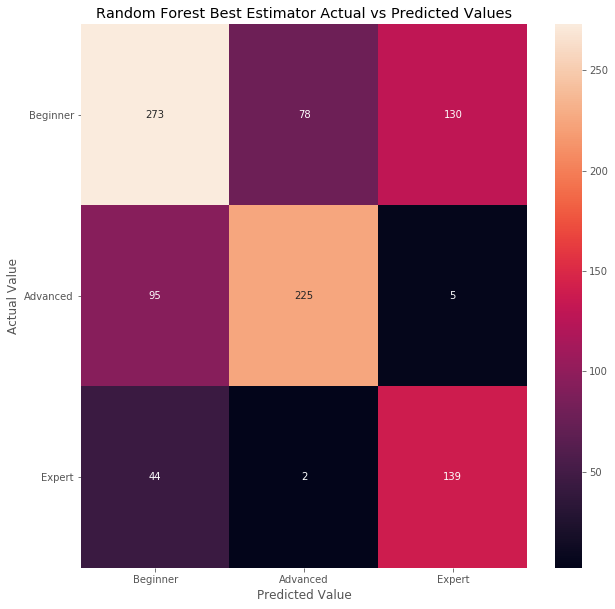

In [298]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(final_y_test, y_pred), annot = True, fmt = 'g', 
            xticklabels = ['Beginner', 'Advanced', 'Expert'], 
            yticklabels = ['Beginner', 'Advanced', 'Expert'])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.yticks(rotation = 0)
plt.title("Random Forest Best Estimator Actual vs Predicted Values")